# Kaggle Competition : Home Credit Default Risk

### Using Under-sampling and Over-sampling (SMOTE) Technique

> Predict how capable each applicant is of repaying a loan.

References:<br>
[Data Sources](https://www.kaggle.com/c/home-credit-default-risk/data) <br>
[Credit Fraud || Dealing with Imbalanced Datasets](https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets)<br>
[信用卡詐騙分析-不平衡資料分析與處理](https://medium.com/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92%E7%9F%A5%E8%AD%98%E6%AD%B7%E7%A8%8B/%E4%BF%A1%E7%94%A8%E5%8D%A1%E8%A9%90%E9%A8%99%E5%88%86%E6%9E%90-%E4%B8%8D%E5%B9%B3%E8%A1%A1%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90%E8%88%87%E8%99%95%E7%90%86kernel%E7%BF%BB%E8%AD%AFpart1-7f1b0a645f9a)<br><br>

task:

> 1. Check dataset

> 2. Data Processing

> 3. Under-sampling

> 4. Over-sampling (SMOTE Technique)


# 1. Check dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')

In [3]:
df.shape

(307511, 122)

In [4]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


#### inbalanced data

91% of data is 0 (loans that were repaid on time), 8% of data is 1 (loans that were not repaid on time). 

In [5]:
df['TARGET'].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

#### train test split

In [6]:
# define training and testing data
y = df['TARGET']
X = df.copy().drop(columns = ['TARGET', 'SK_ID_CURR'])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
df_train = pd.DataFrame(X_train, columns = X.columns)
df_test  = pd.DataFrame(X_test, columns = X.columns)

In [9]:
print(df_train.shape)
print(df_test.shape)

(246008, 120)
(61503, 120)


In [10]:
df_train.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
123473,Cash loans,F,Y,N,0,171000.0,555273.0,16366.5,463500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
10118,Cash loans,M,N,Y,1,157500.0,198085.5,23638.5,171000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
64716,Cash loans,M,Y,Y,0,135000.0,776304.0,25173.0,648000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
234940,Cash loans,M,Y,Y,1,164133.0,900000.0,36787.5,900000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
236051,Cash loans,M,N,Y,0,225000.0,533668.5,21294.0,477000.0,"Spouse, partner",...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0


# 2. Data Processing

task:

> a. Outlinear

> b. Missing value

> c. Transform categorical data

> d. Scaling

#### a. deal with Outlinear

We find anomalies when **df_train['DAYS_EMPLOYED'] == 365243**. 

Let's fill in the anomalous values with **np.nan** and create a new boolean column **'DAYS_EMPLOYED_ANOM'** indicating whether or not the value was anomalous.

In [11]:
# Create an anomalous flag column
df_train['DAYS_EMPLOYED_ANOM'] = df_train["DAYS_EMPLOYED"] == 365243
df_test['DAYS_EMPLOYED_ANOM'] = df_test["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
df_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
df_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)


#### b. Fill in missing value

In [12]:
col_missing_train = list(df_train.columns[df_train.isnull().any()])
col_missing_test = list(df_test.columns[df_test.isnull().any()])

Function from: [Impute categorical missing values in scikit-learn](https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn)

In [13]:
from sklearn.base import TransformerMixin

In [14]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [15]:
imp = DataFrameImputer()
imp.fit(df_train)

df_train = imp.transform(df_train)
df_test = imp.transform(df_test)

In [16]:
# No missing value after imputataion. 

df_test[col_missing_test].isnull().sum(axis = 0)/df_test.shape[0]

AMT_ANNUITY                   0.0
AMT_GOODS_PRICE               0.0
NAME_TYPE_SUITE               0.0
DAYS_EMPLOYED                 0.0
OWN_CAR_AGE                   0.0
                             ... 
AMT_REQ_CREDIT_BUREAU_DAY     0.0
AMT_REQ_CREDIT_BUREAU_WEEK    0.0
AMT_REQ_CREDIT_BUREAU_MON     0.0
AMT_REQ_CREDIT_BUREAU_QRT     0.0
AMT_REQ_CREDIT_BUREAU_YEAR    0.0
Length: 67, dtype: float64

#### b. transform categorical data

* Label encoding  →  columns with 2 unique categories.  <br>
* One-hot encoding  →  columns variable with more than 2 unique categories.

In [17]:
#  columns with 2 unique categories
columns_ob_two = ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE', 'DAYS_EMPLOYED_ANOM']

Label encoding of 2 unique categorical variables

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in columns_ob_two:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

One-hot encoding of more than two unique categorical variable

In [19]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

To remove the columns in the training data that are not in the testing data, we need to align the dataframes. 

In [20]:
# Align the training and testing data, keep only columns present in both dataframes
df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)

print('Training Features shape: ', df_train.shape)
print('Testing Features shape: ', df_test.shape)

Training Features shape:  (246008, 241)
Testing Features shape:  (61503, 241)


In [21]:
df_train.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
123473,0,1,0,0,171000.0,555273.0,16366.5,463500.0,0.035792,-23349,...,1,0,0,0,0,0,0,1,0,0
10118,0,0,1,1,157500.0,198085.5,23638.5,171000.0,0.010032,-10921,...,1,0,0,0,0,0,0,0,1,0
64716,0,1,1,0,135000.0,776304.0,25173.0,648000.0,0.035792,-23213,...,1,0,0,0,0,0,0,1,0,0
234940,0,1,1,1,164133.0,900000.0,36787.5,900000.0,0.030755,-10703,...,0,0,1,0,0,0,0,1,0,0
236051,0,0,1,0,225000.0,533668.5,21294.0,477000.0,0.025164,-15798,...,1,0,0,0,0,0,0,1,0,0


# 3. Under-sampling

#### b. Random Under-Sampling

We want a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. <br>
Then the next step we will implement is to shuffle the data to see if our models can maintain a certain accuracy everytime we run this script.

Warning: The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of information loss.

In [22]:
y_train.value_counts()

0    226132
1     19876
Name: TARGET, dtype: int64

* There are 19,876 cases of Default, so we randomly pick 19,876 cases of non-Default.
* We concat the 19,876 cases of Default and non-Default, creating a new sub-sample.

In [23]:
df_train['TARGET'] = y_train

In [24]:
# Lets shuffle the data before creating the subsamples

df_train_rand = df_train.sample(frac=1)

In [25]:
# calculate the number of Default data
default_df = df_train.loc[df_train['TARGET'] == 1]
n = default_df.shape[0] 

# get the equal amount of Non-Default data
non_default_df = df_train.loc[df_train['TARGET'] == 0][:n]

In [26]:
# concat the 19,876 cases of Default and non-Default, creating a new sub-sample
normal_distributed_df = pd.concat([default_df, non_default_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

In [27]:
print('Shape of Default case: {}'.format(default_df.shape))
print('Shape of Non-Default case: {}'.format(non_default_df.shape))
print('Shape of All cases: {}'.format(new_df.shape))

Shape of Default case: (19876, 242)
Shape of Non-Default case: (19876, 242)
Shape of All cases: (39752, 242)


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

Distribution of the Classes in the subsample dataset


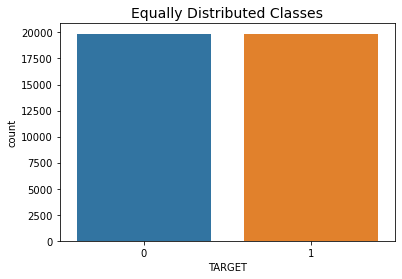

In [29]:
print('Distribution of the Classes in the subsample dataset')

sns.countplot('TARGET', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

#### b. Fit Logistic classifier to examine the result of underfitting

In [30]:
# define training and testing data
y_train = new_df['TARGET']

X_train = new_df.copy().drop(columns = ['TARGET'])
X_test = df_test.copy()

In [31]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [32]:
# Define a pipeline to search for the best combination of classifier regularization.

scaler = MinMaxScaler(feature_range = (0, 1))
logistic = LogisticRegression(max_iter=10000)

pipe = Pipeline(steps=[('scaler', scaler), ('logistic', logistic)])

In [33]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'logistic__penalty': ['l1', 'l2']
}

In [34]:
gs_log = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)

# fitting the model for grid search 
gs_log.fit(X_train , y_train)

# summarize
print('Mean Accuracy: %.3f' % gs_log.best_score_)
print('Config: %s' % gs_log.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  3.9min finished


Mean Accuracy: 0.681
Config: {'logistic__C': 10, 'logistic__penalty': 'l2'}


Don't use accuracy score as a metric with imbalanced datasets (will be usually high and misleading).
Instead, use f1-score, precision/recall score or confusion matrix.

In [35]:
# get classification_report on testing set 

logistic_best = LogisticRegression(C = 10, penalty='l2', max_iter=10000)

pipe_best = Pipeline([('scaler',  scaler ), ('logistic', logistic_best)])
pipe_best.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LogisticRegression(C=10, max_iter=10000))])

In [36]:
from sklearn.metrics import classification_report

In [37]:
y_pred = pipe_best.predict(X_test)
result = classification_report(y_test, y_pred, target_names=['0', '1'])

In [38]:
print(result)

              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56554
           1       0.16      0.67      0.26      4949

    accuracy                           0.68     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.90      0.68      0.76     61503



The recall of Default is higher(0.67), but the Precision of Default is pretty small(0.16). 

# 4. Over-sampling (SMOTE Technique)

[SMOTE for Imbalanced Classification with Python](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

SMOTE stands for Synthetic Minority Over-sampling Technique. <br>
SMOTE creates new synthetic points in order to have an equal balance of the classes. <br>

In [55]:
# define training and testing data
y_train = df_train['TARGET']

X_train = df_train.copy().drop(columns = ['TARGET'])
X_test = df_test.copy()

In [53]:
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [56]:
params_log  = { 'classification__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'classification__penalty': ['l1', 'l2']}

model = Pipeline([
        ('scaler', MinMaxScaler(feature_range = (0, 1))),
        ('sampling', SMOTE()),
        ('classification', LogisticRegression(max_iter=10000))
    ])

gs_log_smote = GridSearchCV(model, params_log, cv=4, n_jobs=-1, verbose=1)
gs_log_smote.fit(X_train, y_train)

Fitting 4 folds for each of 14 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 48.1min
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed: 76.5min finished


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('sampling', SMOTE()),
                                       ('classification',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'classification__C': [0.001, 0.01, 0.1, 1, 10, 100,
                                               1000],
                         'classification__penalty': ['l1', 'l2']},
             verbose=1)

In [57]:
# summarize
print('Mean Accuracy: %.3f' % gs_log_smote.best_score_)
print('Config: %s' % gs_log_smote.best_params_)

Mean Accuracy: 0.697
Config: {'classification__C': 1, 'classification__penalty': 'l2'}


In [ ]:
# get classification_report on testing set 

scaler = MinMaxScaler(feature_range = (0, 1))
logistic_best = LogisticRegression(C = 1, penalty='l2', max_iter=10000)

smote_best = Pipeline([('scaler', scaler),('sampling', SMOTE()), ('logistic', logistic_best)])
smote_best.fit(X_train, y_train)

In [ ]:
y_pred = smote_best.predict(X_test)
result = classification_report(y_test, y_pred, target_names=['0', '1'])

In [ ]:
print(result)